In [3]:
# Required Libraries
import matplotlib.pyplot as plt
plt.style.use('bmh')
import numpy as np
import pandas as pd

In [4]:
# Function: Plot TS
def plot_int_demand(ts, test = [], size_x = 10, size_y = 10, bar_width = 1, prediction = []):
    plt.figure(figsize = (size_x, size_y))
    plt.xticks(rotation = 90)
    plt.rcParams.update({'font.size': 9}) 
    plt.scatter(ts[ts > 0].index.to_pydatetime(), ts[ts > 0], color = 'k', alpha = 0.7, marker = 's')
    plt.bar(ts[ts > 0].index.to_pydatetime(), ts[ts > 0], width = bar_width, color = 'purple', alpha = 0.3)
    if (len(test) > 0):
      plt.scatter(test[test > 0].index.to_pydatetime(), test[test > 0], color = 'k', alpha = 0.7, marker = 's')
      plt.bar(test[test > 0].index.to_pydatetime(), test[test > 0], width = bar_width, color = 'blue', alpha = 0.3)
    if (len(prediction) > 0):
        plt.scatter(prediction[:ts.shape[0]][prediction > 0].index.to_pydatetime(), prediction[:ts.shape[0]][prediction > 0], c = 'orange')
        plt.plot(prediction[:ts.shape[0]].index.to_pydatetime(), prediction[:ts.shape[0]], c = 'red')
        plt.scatter(prediction[ts.shape[0]:][prediction > 0].index.to_pydatetime(), prediction[ts.shape[0]:][prediction > 0], c = 'green')
    return

In [5]:
# Function: V & Q
def v_q_values(ts):
    v = ts[ts > 0]
    q  = []
    x1 = 1
    for i in range(0, ts.shape[0]):
        if (ts[i] > 0):
            x2 = i+1
            zeros = (ts[x1:x2] == 0).sum(axis = 0)
            if (zeros >= 0):
                q.append(zeros)
                x1 = x2-1
    return v, np.asarray(q)

In [7]:
# Function: Classification
def classification(ts):
    v, q         = v_q_values(ts)
    adi          = sum(q)/len(v)
    cv_squared   = ( sum( ( (v - ts.mean() )**2)/ len(ts) )/ ts.mean() )
    f_type = 'Smooth'
    if (adi > 1.32 and cv_squared < 0.49 ):
      f_type = 'Intermittent'
    elif (adi > 1.32 and cv_squared > 0.49 ):
      f_type = 'Lumpy'
    elif (adi < 1.32 and cv_squared > 0.49 ):
      f_type = 'Erratic'
    print('ADI: ', round(adi, 3), ', CV: ', round(cv_squared, 3), ', Type: ', f_type)
    return adi, cv_squared

In [8]:
# Function: MASE (Mean Absolute Scaled Error)
def mase(ts, prediction):
    divisor = 0
    for i in range(1, ts.shape[0]):
        divisor = divisor + abs(ts[i] - ts[i-1])
    divisor = divisor/(ts.shape[0] - 1)
    diff    = abs(ts - prediction[:ts.shape[0]])/divisor
    mase    = diff.mean()
    return mase

# Function: RMSE (Root Mean Squared Error)
def rmse(ts, prediction):
    diff = (ts - prediction[:ts.shape[0]])**2
    mse  = diff.mean()
    return mse**(1/2)

In [9]:
# Function: Croston Method ( https://doi.org/10.2307/3007885 )
def croston_method(ts, alpha = 0.1, n_steps = 1):
    v, q = v_q_values(ts)
    v_i  = ts.copy(deep = True)
    q_i  = ts.copy(deep = True)
    f_i  = ts.copy(deep = True)
    v_i.values[:] = 0
    q_i.values[:] = 0
    f_i.values[:] = 0
    date_idx      = ts.index  
    v_i[0]        = ts[0]  
    q_i[0]        = 1 
    f_i[0]        = v_i[0]/q_i[0]
    for i in range(0, ts.shape[0]-1):
        if (ts[i] > 0):
            idx_1 = ts.index.get_loc(date_idx[i])
            idx_2 =  v.index.get_loc(date_idx[i])
            v_i[idx_1+1] = alpha*v[idx_2] + (1 - alpha)*v_i[idx_1]
            q_i[idx_1+1] = alpha*q[idx_2] + (1 - alpha)*q_i[idx_1]
            if (q_i[idx_1+1] != 0):
                f_i[idx_1+1] = v_i[idx_1+1]/q_i[idx_1+1]
            else:
                f_i[idx_1+1] = v_i[idx_1]
        else:
            idx_1 = ts.index.get_loc(date_idx[i])
            v_i[idx_1+1] = v_i[idx_1]
            q_i[idx_1+1] = q_i[idx_1]
            if (q_i[idx_1+1] != 0):
                f_i[idx_1+1] = v_i[idx_1+1]/q_i[idx_1+1]
            else:
                f_i[idx_1+1] = v_i[idx_1]
    idx = pd.date_range(f_i.index[-1], periods = n_steps, freq = '1d')[1:]
    f_i = f_i.append(pd.Series(np.repeat(f_i[-1], len(idx)), index = idx))    
    return v_i, q_i, f_i

In [23]:
# Load Dataset
data = {
        'DATE': pd.Series(['21/08/2020','22/08/2020', '23/08/2020', '24/08/2020', '25/08/2020', '26/08/2020', '27/08/2020', '28/08/2020', '29/08/2020', '30/08/2020', '31/08/2020', '01/09/2020']),
       'Value': pd.Series([5, 0, 0, 5, 0, 0, 7, 0, 6, 0, 6, 0]),
       }
dataset = pd.DataFrame(data)
dataset['DATE'] = pd.to_datetime(dataset['DATE']).map(lambda x: x.strftime('%d-%m-%Y'))
dataset

,DATE,Value
0,21-08-2020,5
1,22-08-2020,0
2,23-08-2020,0
3,24-08-2020,5
4,25-08-2020,0
5,26-08-2020,0
6,27-08-2020,7
7,28-08-2020,0
8,29-08-2020,6
9,30-08-2020,0


In [24]:
# Prepare Time Series TS
ts       = dataset['Value'].copy(deep = True)
ts.index = pd.DatetimeIndex(dataset['DATE'])
ts       = ts.sort_index()
ts       = ts.reindex(pd.date_range(ts.index.min(), ts.index.max()), fill_value = 0)
ts       = ts.loc[ts[(ts != 0)].first_valid_index():]

print('')
print('Total Number of Observations: ', ts.shape[0])
print('Total Number of Zeros: ', len(ts[ts == 0]))
print('Start Date: ', ts.index[0])
print('End Date: '  , ts.index[-1])
print('')


Total Number of Observations:  12
Total Number of Zeros:  7
Start Date:  2020-08-21 00:00:00
End Date:  2020-09-01 00:00:00



In [25]:
# Time Series Classification
adi, cv_sq = classification(ts)

ADI:  1.2 , CV:  2.07 , Type:  Erratic


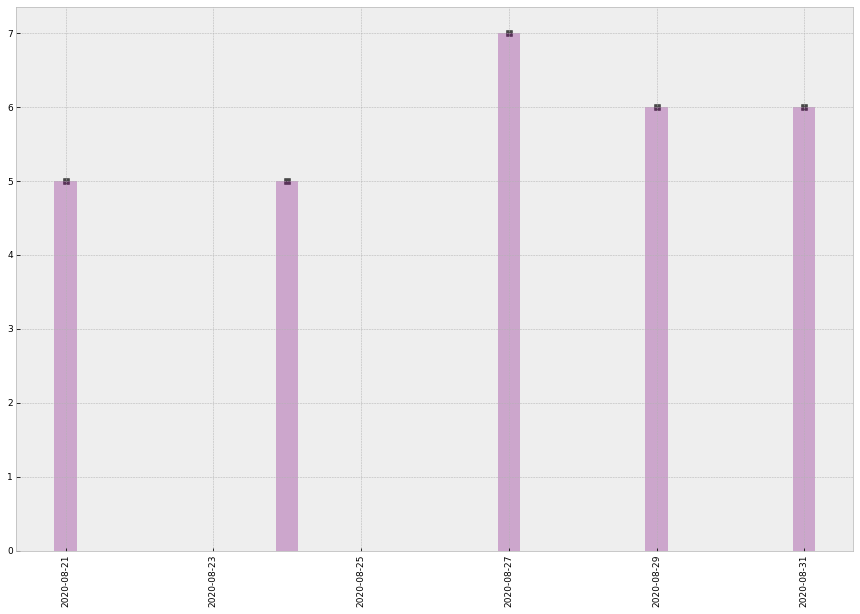

In [26]:
# Time Series Plot
plot_int_demand(ts, size_x = 15, size_y = 10, bar_width = 0.3)

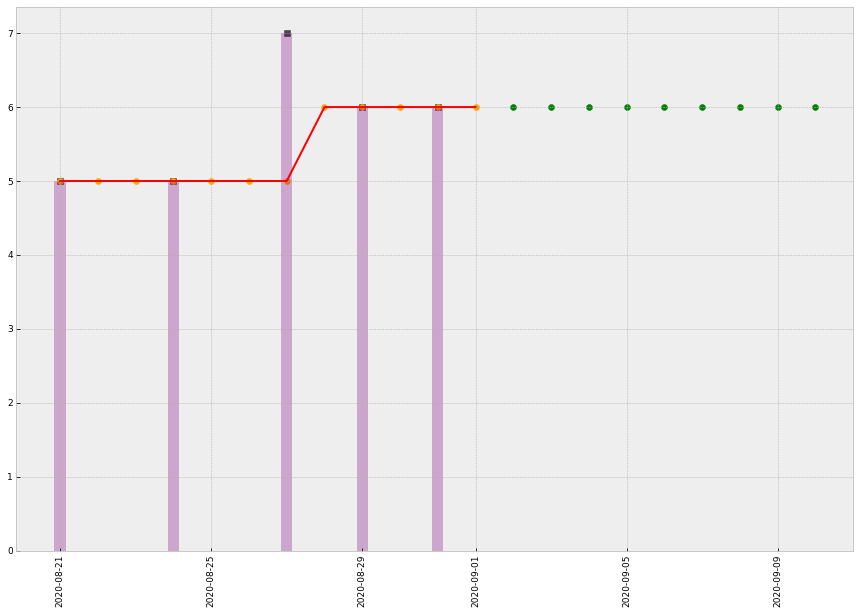

In [30]:
# Croston
v, q, forecast = croston_method(ts, alpha = 0.5, n_steps = 10)
plot_int_demand(ts, size_x = 15, size_y = 10, bar_width = 0.3, prediction = forecast)

In [31]:
forecast

2020-08-21    5
2020-08-22    5
2020-08-23    5
2020-08-24    5
2020-08-25    5
2020-08-26    5
2020-08-27    5
2020-08-28    6
2020-08-29    6
2020-08-30    6
2020-08-31    6
2020-09-01    6
2020-09-02    6
2020-09-03    6
2020-09-04    6
2020-09-05    6
2020-09-06    6
2020-09-07    6
2020-09-08    6
2020-09-09    6
2020-09-10    6
Freq: D, dtype: int64

In [28]:
# Error
print('MASE = ', round(mase(ts, forecast), 3), ', RMSE = ', round(rmse(ts, forecast), 3))

MASE =  0.692 , RMSE =  4.203
